# Comparing ALCS Latent-Learning capabilities

Approach to compare *latent-learning* capabilities of various ALCS systems.

The following aspects will be compared:

- ability learn consequences of performing action in certain states (build accurate internal model of the environment),
- ability to generalize,
- size of internal classifier population,
- relative operation time

In [1]:
import os
import pathlib
import dill
import random

import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import cm

from lcs import Perception
from lcs.agents import EnvironmentAdapter

import gym


# Logger
# import logging
# logging.basicConfig(level=logging.DEBUG)

# Common plot settings
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2

# Common color palette
palette = cm.get_cmap('Paired', 5)

COLORS = {
    'acs': palette(0),
    'acs2': palette(1),
    'acs2_ga': palette(2),
    'yacs': palette(3),
    'dynaq': palette(4),
}

In [2]:
# Import common utils code
%run utils/experiments.py
%run utils/plotting.py

In [3]:
# Cache function result into file (no-need for recomputation)
def get_from_cache_or_run(cache_path, fun):
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)

    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return dill.load(f)
    else:
        res = fun()

        # save the results to file
        with open(cache_path, 'wb') as f:
            dill.dump(res, f)

        return res
    
cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/alcs_comparison/cache/'

# Environments
This section presents the multi-step environments that were used in experiments.

1. [Simple Maze](#Simple-Maze) - Simpler maze variant with limited perception and available actions

Discretized real-valued.

2. [Corridor](#Corridor) - one dimension and two actions are available. The agent is checked is optimal number of classifiers is created
3. [Grid](#Grid) - two dimensions and four actions.

Maybe (todo)

4. Maze4 / Maze6 - More advanced mazes (bigger perception and available actions)

## Simple Maze
In each trial the agent is placed in __S__ tile. It can perceive 4 values (N, E, S and W) and can move in each cardinal direction. The trial ends when tile **F** is reached.

![simple-maze](img/simple-maze.png)

Minimal number of classifiers to model the environment is __20__. The number of _"fully-specialized"_ classifiers is **32**.

In [31]:
import gym_yacs_simple_maze

simple_maze = gym.make('SimpleMaze-v0')
simple_maze_perceptions = simple_maze.env.PERCEPTIONS
simple_maze_transitions = simple_maze.env.TRANSITIONS

# LCS helpers
def simple_maze_knowledge(pop, env):
    all_transitions = 0
    nr_correct = 0

    for s0, action_states in env.env.TRANSITIONS.items():
        for action_state in action_states:
            all_transitions += 1

            action = action_state.action.value
            s1 = action_state.state

            p0 = env.env._perception(s0)
            p1 = env.env._perception(s1)
            
            if any([True for cl in pop if cl.predicts_successfully(p0, action, p1)]):
                nr_correct += 1
            
    return nr_correct / all_transitions

def simple_maze_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': simple_maze_knowledge(population, env),
        'generalization': generalization_score(population)
    }

# DynaQ helpers
def simple_maze_perception_to_int(p0):
    p0m = list(map(int, p0))
    return list(simple_maze_perceptions.keys())[list(simple_maze_perceptions.values()).index(p0m)]

def simple_maze_knowledge_calculator(model, env):
    all_transitions = 0
    nr_correct = 0

    for s0, moves in simple_maze_transitions.items():
        for move in moves:
            a = move.action.value
            s1 = move.state
            
            all_transitions += 1
            if s0 in model and a in model[s0] and model[s0][a][0] == s1:
                nr_correct += 1

    return nr_correct / all_transitions

In [32]:
%%time


common_params = {
    'env': simple_maze,
    'classifier_length': 4,
    'possible_actions': 4,
    'learning_rate': 0.1,
    'environment_adapter': EnvironmentAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': simple_maze_metrics_collect,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [2, 2, 2, 2]
}

dynaq_params = {
    'num_states': len(simple_maze_perceptions),
    'perception_to_state_mapper': simple_maze_perception_to_int,
    'knowledge_fcn': simple_maze_knowledge_calculator
}

simple_maze_metrics = get_from_cache_or_run(
    f'{cache_prefix}/SimpleMaze-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=3))

simple_maze_metrics

Executing 0 experiment
Executing 1 experiment
Executing 2 experiment
CPU times: user 1min, sys: 3.68 ms, total: 1min
Wall time: 1min


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.040825   0.600000   13.666667        0.593720          NaN
      1      0.007682   0.688889   15.333333        0.576537          NaN
      2      0.006081   0.755556   16.333333        0.570235          NaN
      3      0.010245   0.755556   16.333333        0.570235          NaN
      4      0.017088   0.822222   17.666667        0.565126          NaN
...               ...        ...         ...             ...          ...
yacs  245    0.012034   1.000000   23.000000        0.304581          NaN
      246    0.019806   1.000000   23.000000        0.304581          NaN
      247    0.063608   1.000000   23.000000        0.304581          NaN
      248    0.037439   1.000000   23.000000        0.304581          NaN
      249    0.067340   1.000000   23.000000        0.304581          NaN

[1250 rows x 5 columns]

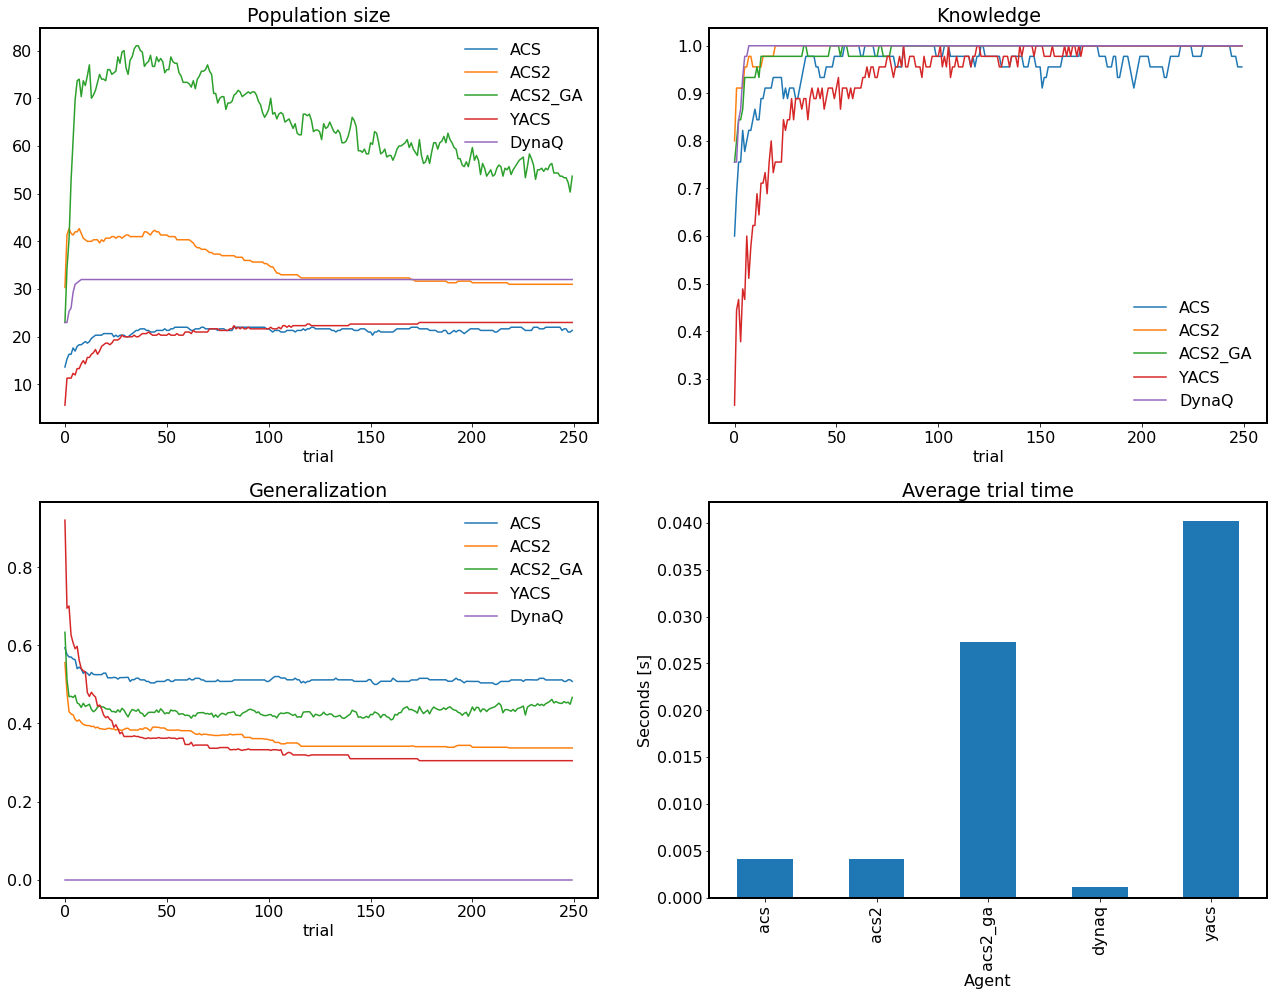

In [33]:
plot_comparison(simple_maze_metrics)
plt.show()

## Corridor

![corridor](img/corridor.png)

In [8]:
import gym_corridor

# LCS helpers
def corridor_knowledge(pop, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in pop if c.is_reliable()]
    nr_correct = 0

    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))

        if any(
            [True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1

    return nr_correct / len(transitions)


def corridor_metrics_collect(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': corridor_knowledge(population, env),
        'generalization': generalization_score(population)
    }


class CorridorAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return [str(phenotype)]


# DynaQ helpers
def dynaq_corridor_knowledge_calculator(model, env):
    transitions = env.env.get_transitions()
    nr_correct = 0

    for (s0, a, s1) in transitions:
        if s0 in model and a in model[s0] and model[s0][a][0] == s1:
            nr_correct += 1

    return nr_correct / len(transitions)

In [9]:
%%time

corridor = gym.make('corridor-20-v0')

common_params = {
    'env': corridor,
    'classifier_length': 1,
    'possible_actions': 2,
    'learning_rate': 0.1,
    'environment_adapter': CorridorAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': corridor_metrics_collect,
    'explore_trials': 250
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [19]
}

dynaq_params = {
    'num_states': corridor.env.observation_space.n,
    'knowledge_fcn': dynaq_corridor_knowledge_calculator
}

corridor_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Corridor-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=3))

corridor_metrics

CPU times: user 2.17 ms, sys: 0 ns, total: 2.17 ms
Wall time: 1.8 ms


time  knowledge  population  generalization  trial_steps
agent trial                                                              
acs   0      0.011691   0.036036   22.000000        0.096752          NaN
      1      0.005908   0.045045   31.666667        0.064050          NaN
      2      0.002253   0.045045   32.666667        0.062030          NaN
      3      0.002007   0.045045   34.000000        0.059251          NaN
      4      0.001589   0.045045   34.333333        0.058657          NaN
...               ...        ...         ...             ...          ...
yacs  245    0.035157   1.000000   38.000000        0.000000          NaN
      246    0.082919   1.000000   38.000000        0.000000          NaN
      247    0.085325   1.000000   38.000000        0.000000          NaN
      248    0.036119   1.000000   38.000000        0.000000          NaN
      249    0.075901   1.000000   38.000000        0.000000          NaN

[1250 rows x 5 columns]

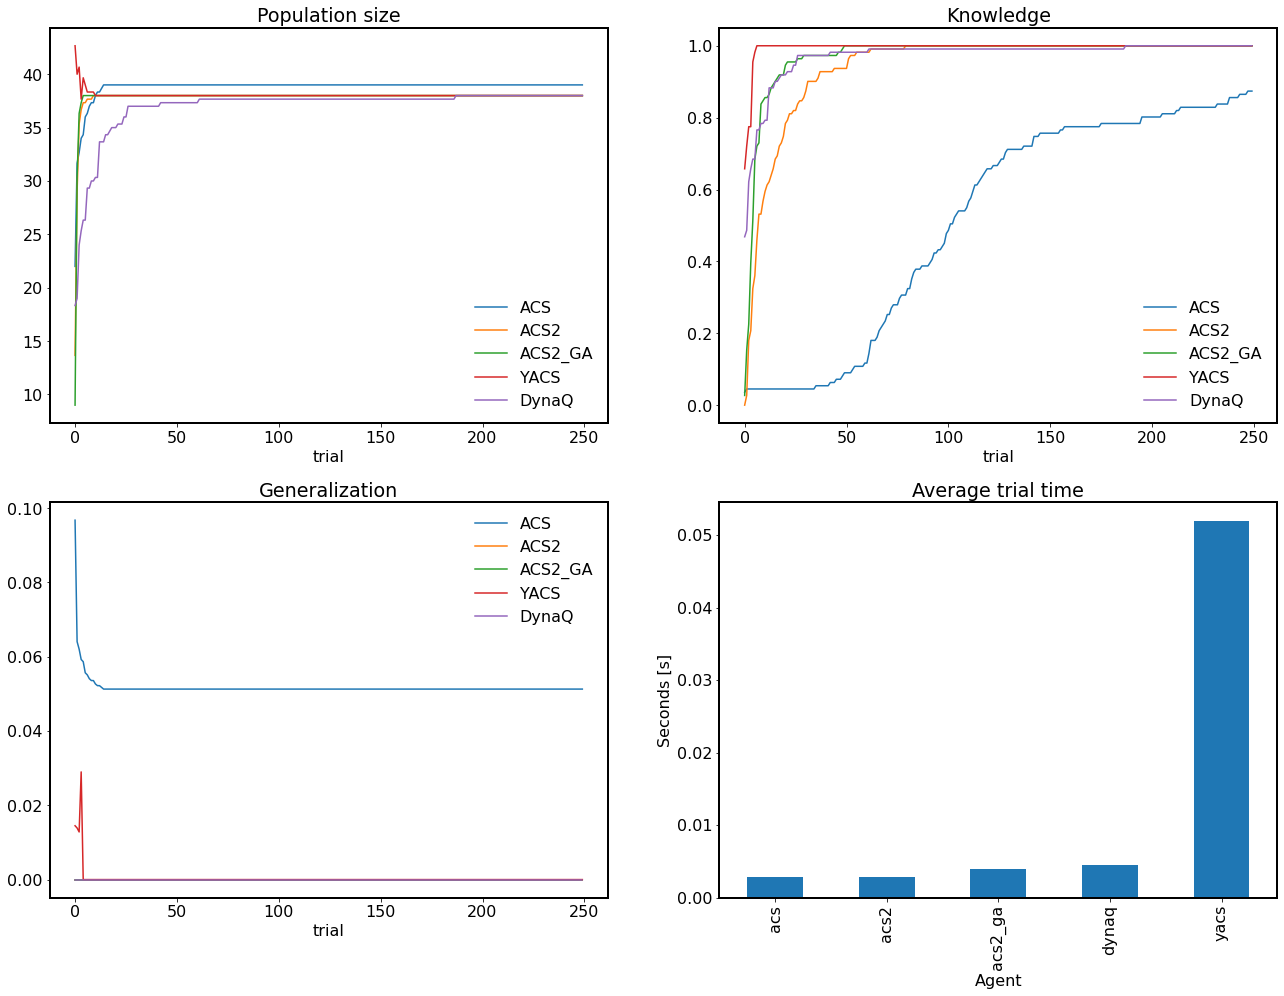

In [10]:
plot_comparison(corridor_metrics)

## Grid
![grid](img/grid.png)

In [11]:
import gym_grid


def grid_knowledge(population, env):
    transitions = env.env.get_transitions()
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception([str(el) for el in start])
        p1 = Perception([str(el) for el in end])
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions)

def grid_metrics(agent, env):
    population = agent.population
    return {
        'pop': len(population),
        'knowledge': grid_knowledge(population, env),
        'generalization': generalization_score(population)
    }

In [12]:
%%time

grid = gym.make('grid-20-v0')

common_params = {
    'env': grid,
    'classifier_length': 2,
    'possible_actions': 4,
    'environment_adapter': EnvironmentAdapter,
    'metrics_trial_freq': 1,
    'metrics_fcn': grid_metrics,
    'explore_trials': 50
}

yacs_params = {
    'trace_length': 3,
    'feature_possible_values': [20, 20]
}

dynaq_params = {
    'num_states': grid.env.observation_space.n,
    'knowledge_fcn': dynaq_corridor_knowledge_calculator
}

grid_metrics = get_from_cache_or_run(
    f'{cache_prefix}/Grid-metrics.dill', 
    lambda: avg_experiments(lambda: run_experiment(common_params, yacs_params=yacs_params, dynaq_params=dynaq_params), n=2))

grid_metrics

CPU times: user 0 ns, sys: 3.39 ms, total: 3.39 ms
Wall time: 3.08 ms


time  knowledge  population  generalization
agent trial                                                 
acs   0      0.314832  12.483531        67.0        0.530092
      1      0.183187  18.412385        72.5        0.527598
      2      0.348146  26.976285        76.5        0.526145
      3      0.243933  34.848485        77.0        0.525974
      4      0.196466  41.403162        77.0        0.525974
...               ...        ...         ...             ...
yacs  45     6.072110  95.685112       446.0        0.263255
      46     5.948170  95.685112       446.0        0.263255
      47     4.495235  95.685112       446.0        0.263255
      48     8.662238  95.685112       446.0        0.263255
      49     8.926037  95.685112       446.0        0.263255

[200 rows x 4 columns]

In [13]:
# grid_metrics.loc['yacs']

In [14]:
#plot_comparison(grid_metrics)

## Conclusions

First obvious points:
- YACS is over-specialising and slow,
- YACS handles big dimensions (Grid environment) poorly